<a href="https://colab.research.google.com/github/ViniciusTavaresSousa/Variational-Autoencoders-VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from keras import ops
import keras
import tensorflow_datasets as tfds
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.util import random_noise

#**Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Base de Dados**

In [ ]:
imagens_treinamento = np.load("/content/drive/MyDrive/VAE/celeba.npy")

In [ ]:
# Redimensiona as imagens para o formato adequado e as normaliza
imagens_treinamento = imagens_treinamento.astype('float32')
imagens_treinamento = imagens_treinamento / 255.0

#**VAE**

In [ ]:
input_shape = [64, 64, 1]  # Forma das imagens de entrada
latent_size = 150  # Tamanho do vetor latente

##**Reparametrização**

In [410]:
# Essa camada é responsável por realizar a amostragem do espaço latente, essencial para o VAE.
@keras.saving.register_keras_serializable()
class Reparametrizacao(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = ops.shape(z_mean)[0]

        dim = ops.shape(z_mean)[1]

        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)

        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

##**Encoder**

In [412]:
def criaEncoder():

    entrada = tf.keras.Input(shape=input_shape)

    # Camadas convolucionais seguidas de LeakyReLU e BatchNormalization
    x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    # Flatten e camada densa para o vetor latente
    x = layers.Flatten()(x)

    z_mean = layers.Dense(latent_size, name = "z_mean")(x)

    z_log_var = layers.Dense(latent_size, name = "z_log_var")(x)

    z = Reparametrizacao()([z_mean, z_log_var])

    # Criação do modelo
    modelo = tf.keras.Model(entrada, [z_mean, z_log_var, z], name="Encoder")
    modelo.summary()

    return modelo

In [413]:
encoder = criaEncoder()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43            │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 32, 32, 16)     │            416 │ input_layer_43[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_181           │ (None, 32, 32, 16)     │              0 │ conv2d_115[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_181   │ (None, 32, 32, 16)     │             64 │ leaky_re_lu_181[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 16, 16, 32)     │         12,832 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_182           │ (None, 16, 16, 32)     │              0 │ conv2d_116[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_182   │ (None, 16, 16, 32)     │            128 │ leaky_re_lu_182[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 8, 8, 64)       │         51,264 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_183           │ (None, 8, 8, 64)       │              0 │ conv2d_117[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_183   │ (None, 8, 8, 64)       │            256 │ leaky_re_lu_183[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 4, 4, 128)      │        204,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_184           │ (None, 4, 4, 128)      │              0 │ conv2d_118[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_184   │ (None, 4, 4, 128)      │            512 │ leaky_re_lu_184[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 2, 2, 256)      │        819,456 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_185           │ (None, 2, 2, 256)      │              0 │ conv2d_119[0][0]       │
│ (LeakyReLU)          

 Total params: 1,398,380 (5.33 MB)

 Trainable params: 1,397,388 (5.33 MB)

 Non-trainable params: 992 (3.88 KB)

##**Decoder**

In [ ]:
# Função para criar o decoder
def criaDecoder():
    entrada = tf.keras.Input(shape=(latent_size,))

    # Camada densa seguida de Reshape e camadas transpostas convolucionais
    x = layers.Dense(2 * 2 * 256, activation="relu")(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Reshape((2, 2, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    saida = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(x)

    # Criação do modelo
    modelo = tf.keras.Model(entrada, saida, name="Decoder")
    modelo.summary()

    return modelo

In [ ]:
decoder = criaDecoder()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)          │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1024)                │         154,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_170 (LeakyReLU)          │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_170              │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_17 (Reshape)                 │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_61                  │ (None, 2, 2, 128)           │         819,328 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_171 (LeakyReLU)          │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_171              │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_62                  │ (None, 4, 4, 64)            │         204,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_172 (LeakyReLU)          │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_172              │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_63                  │ (None, 8, 8, 32)            │          51,232 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_173 (LeakyReLU)          │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_173              │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_64                  │ (None, 16, 16, 16)          │          12,816 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_174 (LeakyReLU)          │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_174              │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,251,361 (4.77 MB)

 Trainable params: 1,248,817 (4.76 MB)

 Non-trainable params: 2,544 (9.94 KB)

##**VAE**

In [414]:
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # O construtor inicializa o modelo com um encoder e um decoder, além de três métricas para acompanhar o treinamento
        self.encoder = encoder
        self.decoder = decoder
        self.perda_total_tracker = keras.metrics.Mean(name="Perda - Total")
        self.perda_reconstrucao_tracker = keras.metrics.Mean(name="Perda - Reconstrução")
        self.perda_KL_tracker = keras.metrics.Mean(name="Perda - KL")

    @property
    def metrics(self):
        # As métricas são utilizadas para monitorar o progresso do treinamento
        return [
            self.perda_total_tracker,
            self.perda_reconstrucao_tracker,
            self.perda_KL_tracker,
        ]

    def train_step(self, entrada):
        with tf.GradientTape() as tape:

            # O encoder gera a média, log da variância e o vetor latente
            z_mean, z_log_var, z = self.encoder(entrada)

            # O decoder gera a reconstrução do dado a partir do vetor latente
            saida = self.decoder(z)

            # Calcula a perda de reconstrução com base na diferença entre a entrada e a saída do decoder
            perda_reconstrucao = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(entrada, saida), axis=(1, 2)))

            # Calcula a perda KL (Kullback-Leibler), que mede a divergência entre a distribuição aprendida e a distribuição normal, mutiliplicada por um peso beta (0.5)
            perda_kl = 0.5 * (-0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)))

            # A perda total é a soma das perdas de reconstrução e KL
            perda_total = perda_reconstrucao + perda_kl

        # Calcula os gradientes em relação aos pesos treináveis do modelo.
        gradientes = tape.gradient(perda_total, self.trainable_weights)

        # Aplica os gradientes para atualizar os pesos do modelo.
        self.optimizer.apply_gradients(zip(gradientes, self.trainable_weights))

        # Atualiza as métricas com os valores calculados durante o treinamento
        self.perda_total_tracker.update_state(perda_total)
        self.perda_reconstrucao_tracker.update_state(perda_reconstrucao)
        self.perda_KL_tracker.update_state(perda_kl)

        # Retorna as métricas de treinamento
        return {
            "Perda - Total": self.perda_total_tracker.result(),
            "Perda - Reconstrução": self.perda_reconstrucao_tracker.result(),
            "Perda - KL": self.perda_KL_tracker.result(),
        }

    def get_config(self):
        # O método get_config retorna a configuração necessária para salvar o modelo
        config = super().get_config()

        # A configuração inclui o encoder e o decoder, que são serializados
        config.update({
            "encoder": keras.saving.serialize_keras_object(self.encoder),
            "decoder": keras.saving.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        # O método from_config permite restaurar o modelo a partir da configuração salva
        encoder = keras.saving.deserialize_keras_object(config.pop("encoder"))
        decoder = keras.saving.deserialize_keras_object(config.pop("decoder"))

        # Retorna uma nova instância do modelo VAE com o encoder e decoder restaurados
        return cls(encoder=encoder, decoder=decoder, **config)

##**Treinamento**

In [ ]:
# Compila e treina o modelo
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001))
vae.fit(imagens_treinamento, epochs=200, batch_size=32)

Epoch 1/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - Perda - KL: 16.6151 - Perda - Reconstrução: 2450.9414 - Perda - Total: 2467.5552
Epoch 2/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 25.4120 - Perda - Reconstrução: 2224.5261 - Perda - Total: 2249.9397
Epoch 3/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 26.2965 - Perda - Reconstrução: 2193.2742 - Perda - Total: 2219.5701
Epoch 4/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 27.2122 - Perda - Reconstrução: 2179.1165 - Perda - Total: 2206.3296
Epoch 5/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 28.1206 - Perda - Reconstrução: 2168.0828 - Perda - Total: 2196.2021
Epoch 6/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 29.2147 - Perda - Reconstrução: 2159.6311 - Perda - Total: 2188.8462
Epoch 7/200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Perda - KL: 29.9697 - Perda - Reconstrução: 2156.0273 - Perda - Total: 2185.9966
Epoch 8/200
3125/3125 ━━━━━

In [ ]:
# Salva o modelo completo no formato nativo .keras
vae.save("/content/drive/MyDrive/VAE/vae.keras")

##**Teste**

In [ ]:
# Carrega modelo completo
vae = tf.keras.models.load_model("/content/drive/MyDrive/VAE/vae.keras")

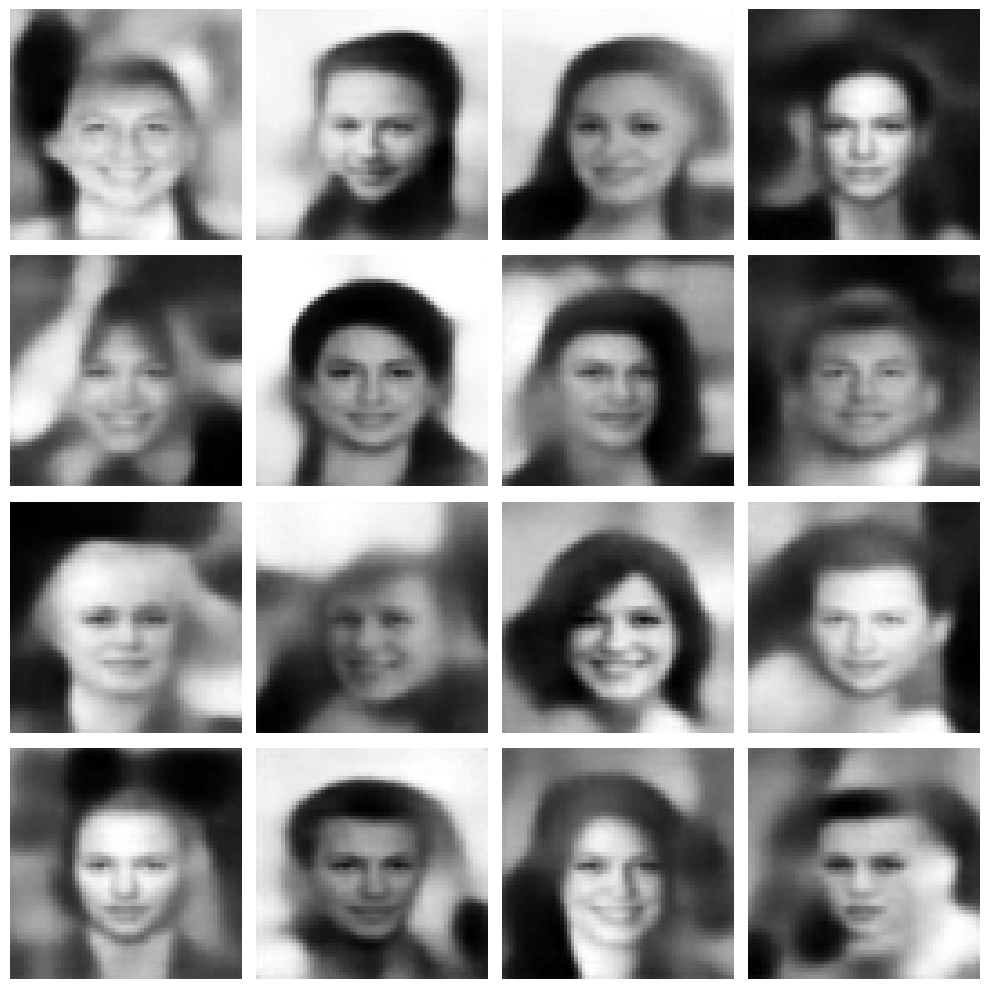

In [415]:
# Gera 16 vetores latentes
vetores_latentes = np.random.normal(size=(16, latent_size))

# Gera imagens usando o decoder
imagens_geradas = vae.decoder(vetores_latentes, training = False)

# Exibe as 16 imagens geradas
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    image = np.squeeze(imagens_geradas[i])  # Remover dimensões extras
    image = (image + 1) * 127.5  # Converter de [-1, 1] para [0, 255]
    image = np.clip(image, 0, 255).astype(np.uint8)  # Garantir que os valores estão entre 0 e 255

    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##**Utilitarios**

In [ ]:
import shutil

# Caminho da pasta que você deseja excluir
folder_path = "/content/drive/MyDrive/VAE/imagens_geradas"

# Exclui a pasta e todo o seu conteúdo
shutil.rmtree(folder_path)

print(f"Pasta '{folder_path}' excluída com sucesso!")

Pasta '/content/drive/MyDrive/VAE/imagens_geradas' excluída com sucesso!


In [ ]:
!pip install git+https://github.com/moflo/celebalocal.git
!pip install tfds_nightly


import tensorflow_datasets as tfds
import celebalocal
ds = tfds.load('celebalocal', split='train')

  Cloning https://github.com/moflo/celebalocal.git to /tmp/pip-req-build-72xwinoj
  Running command git clone --filter=blob:none --quiet https://github.com/moflo/celebalocal.git /tmp/pip-req-build-72xwinoj
  Resolved https://github.com/moflo/celebalocal.git to commit 77ee0a443ed8e9d08d6f74ed1d88e0995b446384
  Preparing metadata (setup.py) ... done
  Created wheel for celebalocal: filename=celebalocal-0.0.1-py3-none-any.whl size=3145 sha256=9abb463c4d04d8bb2c71822b9ba87dbdd3bdc8d6265c3fa20b39558a0aadc75b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldz5ogdc/wheels/22/78/57/be599a306b214c598353a0be7c104cb3edba8bdeb88bda0c28
Successfully built celebalocal
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 70.9 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celebalocal/incomplete.3XI4SX_1.0.0/celebalocal-train.tfrecord*...:   0%| …

Dataset celebalocal downloaded and prepared to /root/tensorflow_datasets/celebalocal/1.0.0. Subsequent calls will reuse this data.


TypeError: Reader.__init__() got multiple values for argument 'example_specs'

1000 imagens processadas...
2000 imagens processadas...
3000 imagens processadas...
4000 imagens processadas...
5000 imagens processadas...
6000 imagens processadas...
7000 imagens processadas...
8000 imagens processadas...
9000 imagens processadas...
10000 imagens processadas...
11000 imagens processadas...
12000 imagens processadas...
13000 imagens processadas...
14000 imagens processadas...
15000 imagens processadas...
16000 imagens processadas...
17000 imagens processadas...
18000 imagens processadas...
19000 imagens processadas...
20000 imagens processadas...
21000 imagens processadas...
22000 imagens processadas...
23000 imagens processadas...
24000 imagens processadas...
25000 imagens processadas...
26000 imagens processadas...
27000 imagens processadas...
28000 imagens processadas...
29000 imagens processadas...
30000 imagens processadas...
31000 imagens processadas...
32000 imagens processadas...
33000 imagens processadas...
34000 imagens processadas...
35000 imagens processad

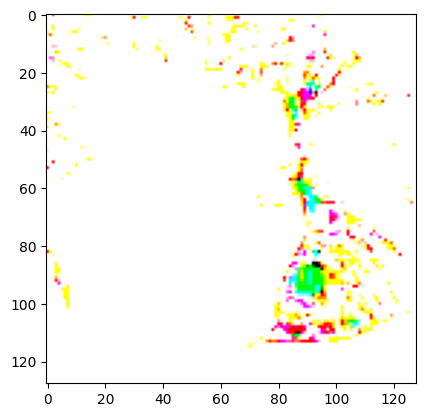

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Função para processar as imagens: redimensionar para 128x128 e manter em RGB
def process_image(image):
    # Redimensionar a imagem para 128x128
    image = tf.image.resize(image, (128, 128))
    # Manter a imagem em RGB (não converte para escala de cinza)
    return image

# Função para carregar imagens do TFRecord
def parse_tfrecord_fn(example):
    # Especificar as características para cada exemplo no TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Imagem é armazenada como uma string
        'label': tf.io.FixedLenFeature([], tf.int64)   # Label (não será usado aqui)
    }
    # Parse do exemplo
    example = tf.io.parse_single_example(example, feature_description)
    # Decodificar a imagem, convertendo de string para um tensor de imagem
    image = tf.io.decode_jpeg(example['image'], channels=3)  # Agora estamos carregando a imagem em RGB
    return process_image(image)  # Processar a imagem

# Caminho para os arquivos TFRecord (todos os arquivos, de 00000 até 00015)
tfrecords_files = [
    f'/root/tensorflow_datasets/celebalocal/1.0.0/celebalocal-train.tfrecord-000{i:02d}-of-00016' for i in range(16)
]

# Criar um dataset a partir de todos os arquivos TFRecord
raw_dataset = tf.data.TFRecordDataset(tfrecords_files)

# Mapear a função de parsing para processar as imagens
processed_dataset = raw_dataset.map(parse_tfrecord_fn)

# Número de imagens que queremos salvar
num_images = 100000

# Lista para armazenar as imagens
images = []

# Carregar e processar as imagens
count = 0
for image in processed_dataset.take(num_images):
    # Adicionar a imagem processada à lista
    images.append(image.numpy())
    count += 1
    if count % 1000 == 0:
        print(f"{count} imagens processadas...")

# Converter a lista de imagens para um array NumPy
images = np.array(images)

# Verificar o formato final
print(f"Formato final das imagens: {images.shape}")

# Salvar o array NumPy com as imagens
np.save('/content/drive/MyDrive/VAE/celeba.npy', images)

# Visualizar uma imagem como exemplo
plt.imshow(images[1])  # A imagem já está no formato RGB
plt.show()
